# Statistical Inference Tutorial (Hypothesis Testing)

## Preparation <a id="1"></a>

In [1]:
# Dependencies

# Standard Dependencies
import os
import numpy as np
import pandas as pd
from math import sqrt

# Visualization
from pylab import *
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from statistics import median
from scipy import signal
from scipy.special import factorial
import scipy.stats as stats
from scipy.stats import sem, binom, lognorm, poisson, bernoulli, spearmanr
from scipy.fftpack import fft, fftshift

# Read in csv of Toy Dataset
# We will use this dataset throughout the tutorial
df = pd.read_csv('example_dataset.csv')

## Hypothesis testing <a id="11"></a>

Hypothesis Testing is a form of inferential statistics that allows us to draw conclusions about an entire population based on a representative sample

We establish two hypotheses, H0 (Null hypothesis) and Ha (Alternative Hypothesis). 

We can make four different decisions with hypothesis testing:
1. Reject H0 and H0 is not true (no error)
2. Do not reject H0 and H0 is true (no error)
3. Reject H0 and H0 is true (Type 1 Error)
4. Do not reject H0 and H0 is not true (Type 2 error)

Type 1 error is also called Alpha error.
Type 2 error is also called Beta error.

![](https://qph.fs.quoracdn.net/main-qimg-84121cf5638cbb5919999b2a8d928c91)

![](https://i.stack.imgur.com/x1GQ1.png)

### P-Value

A p-value is the probability of finding equal or more extreme results when the null hyptohesis (H0) is true. In other words, a low p-value means that we have compelling evidence to reject the null hypothesis.

If the p-value is lower than 5% (p < 0.05). We often reject H0 and accept Ha is true. We say that p < 0.05 is statistically significant, because there is less than 5% chance that we are wrong in rejecting the null hypothesis.

One way to calculate the p-value is through a T-test. We can use [Scipy's ttest_ind function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) to calculate the t-test for the means of two independent samples of scores. In this example we calculate the t-statistic and p-value of two random samples 10 times. 

We see that the p-value is sometimes very low, but this does not mean that these two random samples are correlated. This is why you have to be careful with relying too heavily of p-values. If you repeat an experiment multiple times you can get trapped in the illusion that there is correlation where there is only randomness.

In [2]:
# Perform t-test and compute p value of two random samples
print('T-statistics and p-values of two random samples.')
for _ in range(10):
    rand_sample1 = np.random.random_sample(10)
    rand_sample2 = np.random.random_sample(10)
    print(stats.ttest_ind(rand_sample1, rand_sample2))

T-statistics and p-values of two random samples.
Ttest_indResult(statistic=-0.4077525882336453, pvalue=0.6882642180316848)
Ttest_indResult(statistic=-1.1132606185807263, pvalue=0.28024286052108965)
Ttest_indResult(statistic=-1.3111188801523779, pvalue=0.2062982188075459)
Ttest_indResult(statistic=0.5545353066349491, pvalue=0.5860375019679362)
Ttest_indResult(statistic=1.438252829025716, pvalue=0.16752262996795492)
Ttest_indResult(statistic=-1.010608960584588, pvalue=0.3255966659951387)
Ttest_indResult(statistic=0.6244920425081435, pvalue=0.5401401166063736)
Ttest_indResult(statistic=-0.2329083366678691, pvalue=0.8184604739095204)
Ttest_indResult(statistic=-0.1393822454213072, pvalue=0.8906957816409237)
Ttest_indResult(statistic=0.06490282665346578, pvalue=0.9489667562403805)


### q-q plot (quantile-quantile plot)

Many statistical techniques require that data is coming from a normal distribution (for example, t-test). Therefore, it is important to verify this before applying statistical techniques.

One approach is to visualize and make a judgment about the distribution. A q-q plot is very helpful for determining if a distribution is normal. There are other tests for testing 'normality', but this is beyond the scope of this tutorial.

In the first plot we can easily see that the values line up nicely. From this we conclude that the data is normally distributed.

In the second plot we can see that the values don't line up. Our conclusion is that the data is not normally distributed. In this case the data was uniformly distributed.


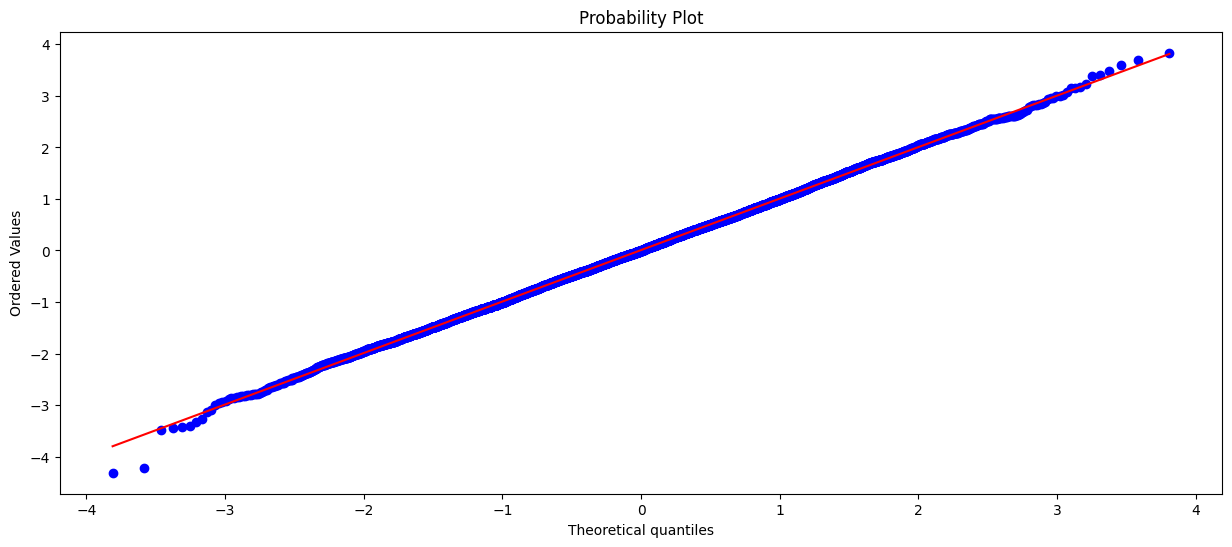

In [4]:
# q-q plot of a normal distribution
normal_dist = np.random.randn(10000)
plt.figure(figsize=(15,6))
stats.probplot(normal_dist, dist="norm", plot=plt)
plt.show()

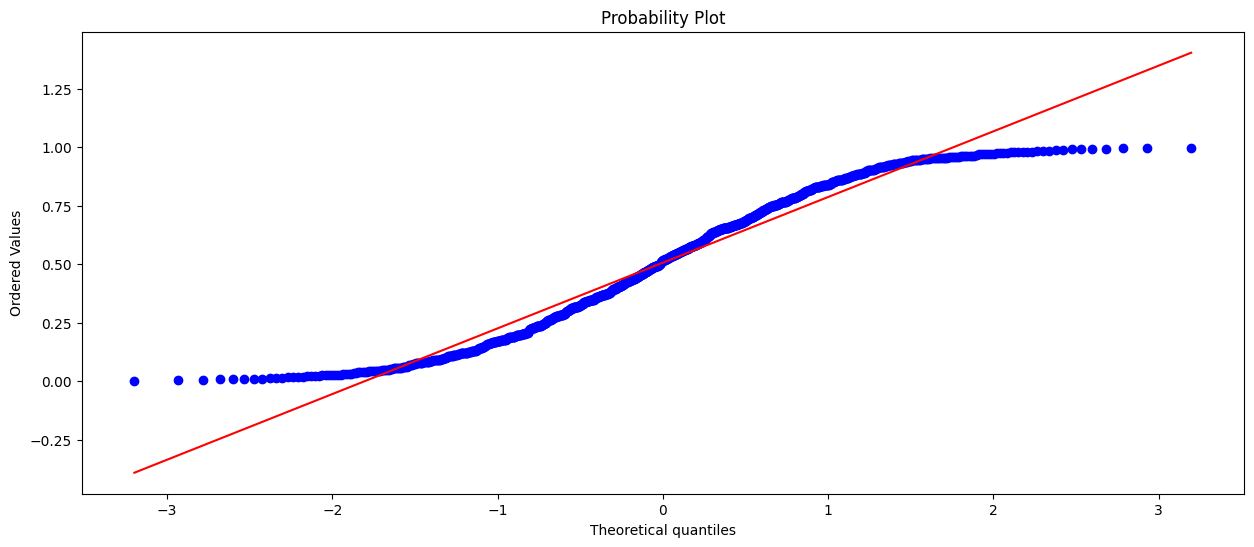

In [6]:
# q-q plot of a uniform/random distribution
uniform_dist = np.random.random(1000)
plt.figure(figsize=(15,6))
stats.probplot(uniform_dist, dist="norm", plot=plt) 
plt.show()

## Outliers <a id="12"></a>

An outlier is an observation which deviates from other observations. An outlier often stands out and could be an error.

Outliers can mess up you statistical models. However, outliers should only be removed when you have established good reasons for removing the outlier.

Sometimes the outliers are the main topic of interest. This is for example the case with fraud detection. There are many outlier detection methods, but here we will discuss Grubbs test and Tukey’s method. Both tests assume that the data is normally distributed.

### Grubbs Test

In Grubbs test, the null hypothesis is that no observation is an outlier, while the alternative hypothesis is that there is one observation an outlier. Thus the Grubbs test is only searching for one outlier observation.

The formula for Grubbs test:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/bafc310f1dbca658728c73256fed19b6a7f11130)

Where Y_hat is the sample mean and s is the standard deviation. The Grubbs test statistic is the largest absolute deviation from the sample mean in units of the sample standard deviation.

[Source](https://en.wikipedia.org/wiki/Grubbs%27_test_for_outliers)

### Tukey's method

Tukey suggested that an observation is an outlier whenever an observation is 1.5 times the interquartile range below the first quartile or 1.5 times the interquartile range above the third quartile. This may sound complicated, but is quite intuitive if you see it visually.

For normal distributions, Tukey’s criteria for outlier observations is unlikely if no outliers are present, but using Tukey’s criteria for other distributions should be taken with a grain of salt.

The formula for Tukey's method:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/2a103bbd9233d9f8f711a7c76dfeb9694446f860)

Ya is the larger of two means being compared. SE is the standard error of the sum of the means.

[Source](https://en.wikipedia.org/wiki/Tukey%27s_range_test)

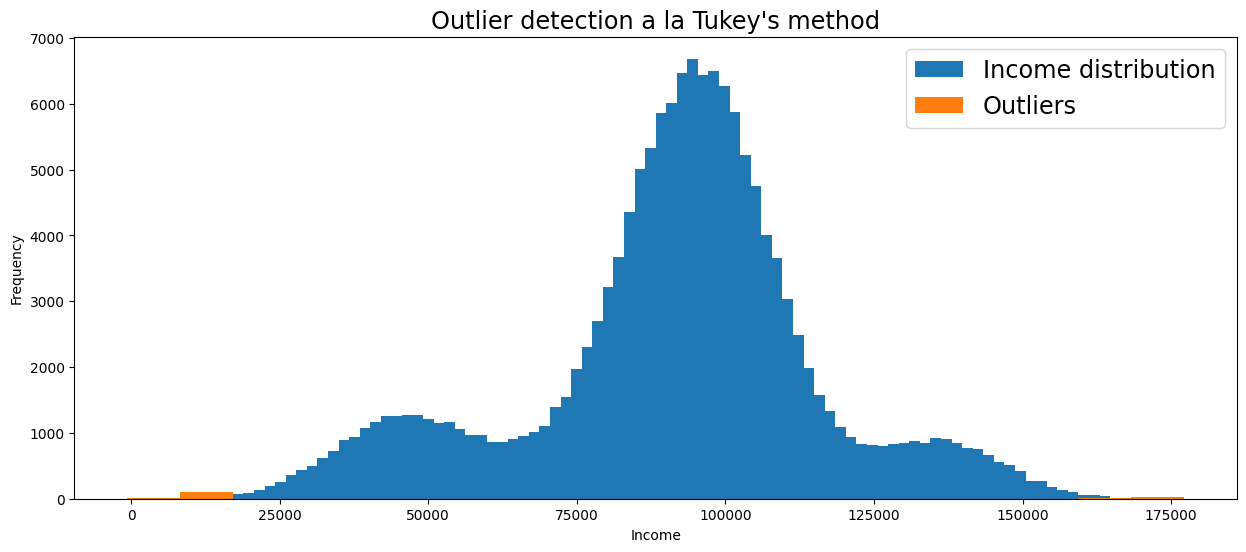

In [7]:
# Detect outliers on the 'Income' column of the Toy Dataset

# Function for detecting outliers a la Tukey's method using z-scores
def tukey_outliers(data) -> list:
    # For more information on calculating the threshold check out:
    # https://medium.com/datadriveninvestor/finding-outliers-in-dataset-using-python-efc3fce6ce32
    threshold = 3
    
    mean = np.mean(data)
    std = np.std(data)
    
    # Spot and collect outliers
    outliers = []
    for i in data:
        z_score = (i - mean) / std
        if abs(z_score) > threshold:
            outliers.append(i)
    return outliers

# Get outliers
income_outliers = tukey_outliers(df['Income'])

# Visualize distribution and outliers
plt.figure(figsize=(15,6))
df['Income'].plot(kind='hist', bins=100, label='Income distribution')
plt.hist(income_outliers, bins=20, label='Outliers')
plt.title("Outlier detection a la Tukey's method", fontsize='xx-large')
plt.xlabel('Income')
plt.legend(fontsize='xx-large')

<h2>ANOVA: Analysis of Variance</h2>
<p>The Analysis of Variance  (ANOVA) is a statistical method used to test whether there are significant differences between the means of two or more groups. ANOVA returns two parameters:</p>

<p><b>F-test score</b>: ANOVA assumes the means of all groups are the same, calculates how much the actual means deviate from the assumption, and reports it as the F-test score. A larger score means there is a larger difference between the means.</p>

<p><b>P-value</b>:  P-value tells how statistically significant is our calculated score value.</p>

<p>If our price variable is strongly correlated with the variable we are analyzing, expect ANOVA to return a sizeable F-test score and a small p-value.</p>

### Example data - Automotive data

In [8]:
path='automotive_pams_clean.csv'
df = pd.read_csv(path)
df.head()

,symboling,normalized-losses,make,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,...,city-mpg,highway-mpg,price,city-L/100km,highway-L/100km,horsepower-binned,fuel-type-diesel,fuel-type-gas,aspiration-std,aspiration-turbo
0,3,122,alfa-romero,two,convertible,rwd,front,88.6,0.811148,0.890278,...,21,27,13495.0,11.190476,8.703704,Low,0,1,1,0
1,3,122,alfa-romero,two,convertible,rwd,front,88.6,0.811148,0.890278,...,21,27,16500.0,11.190476,8.703704,Low,0,1,1,0
2,1,122,alfa-romero,two,hatchback,rwd,front,94.5,0.822681,0.909722,...,19,26,16500.0,12.368421,9.038462,Medium,0,1,1,0
3,2,164,audi,four,sedan,fwd,front,99.8,0.848630,0.919444,...,24,30,13950.0,9.791667,7.833333,Low,0,1,1,0
4,2,164,audi,four,sedan,4wd,front,99.4,0.848630,0.922222,...,18,22,17450.0,13.055556,10.681818,Low,0,1,1,0


#### Drive Wheels

<AxesSubplot:xlabel='drive-wheels', ylabel='price'>

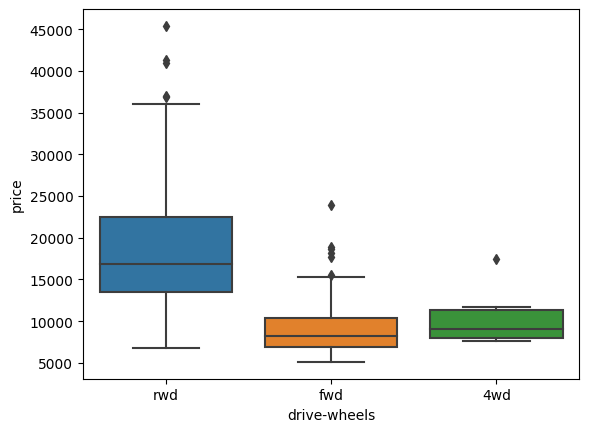

In [11]:
sns.boxplot(x="drive-wheels", y="price", data=df)

Since ANOVA analyzes the difference between different groups of the same variable, the groupby function will come in handy. Because the ANOVA algorithm averages the data automatically, we do not need to take the average before hand.

Let's see if different types 'drive-wheels' impact 'price', we group the data.

In [13]:
# Groupby
grouped_test=df[['drive-wheels', 'price']].groupby(['drive-wheels'])
grouped_test.head(2)

,drive-wheels,price
0,rwd,13495.0
1,rwd,16500.0
3,fwd,13950.0
4,4wd,17450.0
5,fwd,15250.0
136,4wd,7603.0


In [14]:
# We can obtain value of each group
grouped_test.get_group('4wd')['price']

4      17450.0
136     7603.0
140     9233.0
141    11259.0
144     8013.0
145    11694.0
150     7898.0
151     8778.0
Name: price, dtype: float64

we can use the function 'f_oneway' in the module 'stats' to obtain the F-test score and P-value for the ANOVA test

In [16]:
# ANOVA test for 3 groups
f_val, p_val = stats.f_oneway(grouped_test.get_group('fwd')['price'], grouped_test.get_group('rwd')['price'], grouped_test.get_group('4wd')['price'])  
 
print( "ANOVA results: F=", f_val, ", P =", p_val) 

ANOVA results: F= 67.95406500780399 , P = 3.3945443577151245e-23


This is a great result, with a large F test score showing a strong correlation and a P value of almost 0 implying almost certain statistical significance. But does this mean all three tested groups are all this highly correlated?

#### Separately: fwd and rwd

In [18]:
f_val, p_val = stats.f_oneway(grouped_test.get_group('fwd')['price'], grouped_test.get_group('rwd')['price'])  
 
print( "ANOVA results: F=", f_val, ", P =", p_val )

ANOVA results: F= 130.5533160959111 , P = 2.2355306355677845e-23


Let's examine the other groups 

#### 4wd and rwd

In [19]:
f_val, p_val = stats.f_oneway(grouped_test.get_group('4wd')['price'], grouped_test.get_group('rwd')['price'])  
   
print( "ANOVA results: F=", f_val, ", P =", p_val)

ANOVA results: F= 8.580681368924756 , P = 0.004411492211225333


#### 4wd and fwd

In [20]:
f_val, p_val = stats.f_oneway(grouped_test.get_group('4wd')['price'], grouped_test.get_group('fwd')['price'])  
 
print("ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 0.665465750252303 , P = 0.41620116697845666


# The end!